<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/00-03-consolidaci%C3%B3n_train_test_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo 50 JAIIO: Consolidación del dataset
__Título:__ Etiquetado semi-supervisado multiclase de correos electrónicos a partir de estrategias de extracción de características y _Elasticsearch_

__Autores:__ Juan Manuel Fernandez, Marcelo Errecalde


En esta notebook se consolidan las clases de los correos que forman parte del trabajo dado que se encontraron clases solapadas y ejemplos mal clasificados:

## 0. Misceláneos:

### Descarga de librerias necesarias

In [1]:
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=b98d4a2950ac10af2c314c2c7f56029a70f4396fad46f3123221ac6c0c51e8b2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import consolidar_df, get_clases_pre

### Descarga dataset de train y test

Se descargan los datasets con 800 correos en el caso de train y 200 correos para el de test:

In [3]:
# Descargo los correos ya etiquetados
from os import path

if not (path.exists('correos-train-80.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-train-80.csv

if not (path.exists('correos-test-20.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-test-20.csv

--2021-06-15 20:38:26--  https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-train-80.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223169 (218K) [text/plain]
Saving to: ‘correos-train-80.csv’

correos-train-80.cs 100%[===================>] 217.94K  --.-KB/s    in 0.005s  

2021-06-15 20:38:26 (41.9 MB/s) - ‘correos-train-80.csv’ saved [223169/223169]

--2021-06-15 20:38:26--  https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-test-20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP 

## 1. Presentación del dataset:

### 1.1 Se levanta en un DataFrame para poder manipularlo

In [4]:
import pandas as pd

# Cargo correos en un dataframe
correos_train = pd.read_csv('correos-train-80.csv')
correos_test = pd.read_csv('correos-test-20.csv')

## 2. Representación de las clases

Pasan a representarse las clases a partir de la etiqueta y no del valor numérico discretizado:


### 2.1 Transformación de las clases identificadas por el experto

In [5]:
from sklearn.preprocessing import LabelEncoder

clases = get_clases_pre()

# Instancio el transformador
le = LabelEncoder()

# Discretizo
clases_disc = le.fit_transform(clases)

# Muestro clases originales
print(f'Clases originales:\n{clases}\n')

# Muestro clases discretizadas
print(f'Clases discretizadas:\n{clases_disc}\n')

# Accedo a la clase original por su valor discretizado
print(f'Acceso a la original, de id {2} con discretizada: {clases[clases_disc[2]]}')

Clases originales:
['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Carga de Notas' 'Certificados Web' 'Consulta por Equivalencias'
 'Consulta por Legajo' 'Consulta sobre Título Universitario' 'Cursadas'
 'Datos Personales' 'Exámenes' 'Ingreso a la Universidad'
 'Inscripción a Cursadas' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica' 'Vacunas Enfermería']

Clases discretizadas:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Acceso a la original, de id 2 con discretizada: Cambio de Comisión


### 2.2 Unificación del dataset

Se unifica el dataset de train y test en un único dataset. Luego se vuelve a separar en train y test:

In [6]:
import pandas as pd

correos_etiquetados = pd.concat([correos_train, correos_test], ignore_index=True)

### 2.3 Creación de un dataframe con las clases originales sin discretizar

In [7]:
# Aplico una transformacion inversa para des-discretizar
correos_etiquetados['clase'] = le.inverse_transform(correos_etiquetados['clase'])

# Muestro las primeras 5 clases originales
correos_etiquetados['clase'].head(5)

0      Inscripción a Cursadas
1           Cambio de Carrera
2             Reincorporación
3             Reincorporación
4    Ingreso a la Universidad
Name: clase, dtype: object

## 3. Reorganización de las clases

A partir de falencias en el etiquetado encontradas en la construcción del modelo, se mejora el etiquetado en dos aspectos:
1. Se reorganizan las clases,
2. Se re-etiquetan algunas instancias

Además, se guardarán los correos con las clases sin discretizar (etiquetas textuales).


### 3.1 Reorganización de las clases

En este aspecto, se realizan los siguientes cambios:
- La clase 'Vacunas Enfermería' se unifica con 'Reguisitos de Ingreso'.
- La clase 'Inscripción a Cursadas' se unifica con 'Cursadas'.
- La clase 'Certificados Web' se unifica con 'Pedido de Certificados' que a su vez pasa a llamarse 'Emisión de Certificados'.
- La clase 'Carga de Notas' se unifica con 'Situación Académica'.

In [8]:
correos_etiquetados['clase'] = correos_etiquetados['clase'].replace(['Vacunas Enfermería'], 'Requisitos de Ingreso')

In [9]:
correos_etiquetados['clase'] = correos_etiquetados['clase'].replace(['Inscripción a Cursadas'], 'Cursadas')

In [10]:
correos_etiquetados['clase'] = correos_etiquetados['clase'].replace(['Certificados Web'], 'Pedido de Certificados')

In [11]:
correos_etiquetados['clase'] = correos_etiquetados['clase'].replace(['Carga de Notas'], 'Situación Académica')

In [12]:
import numpy as np

np.sort(correos_etiquetados['clase'].unique())

array(['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión',
       'Consulta por Equivalencias', 'Consulta por Legajo',
       'Consulta sobre Título Universitario', 'Cursadas',
       'Datos Personales', 'Exámenes', 'Ingreso a la Universidad',
       'Pedido de Certificados', 'Problemas con la Clave',
       'Reincorporación', 'Requisitos de Ingreso',
       'Simultaneidad de Carreras', 'Situación Académica'], dtype=object)

### 3.2 Re-etiquetado de Instancias

En este aspecto, se vuelven a etiquetar instancias que estaban mal etiquetadas.

En primer lugar se des-setea el ancho de la columna para poder visualizar todo el texto de las consultas:


In [13]:
pd.set_option('display.max_colwidth', None)

El proceso consiste en visualizar el texto de las instancias para asegurarnos del reemplazo correcto con el siguiente código: <br />
`correos_etiquetados.loc[[2]][['Consulta', 'clase']]` <br />
Y luego el reemplazo con el método `at`: <br />
`correos_etiquetados.at[2, 'clase'] = 'Reincorporación'`

Además, se crea una función para realizar modificaciones de clase a partir del texto de la consulta:

In [14]:
def modificar_clase(df, texto_consulta, nueva_clase):
  '''
  Esta función modifica el atributo "clase" asignado a un correo a partir de 
  comparar texto_consulta contra el atributo "Consulta"
  '''
  # Se busca el índice
  indice = int(df.query(f"Consulta == '{texto_consulta}'").index.values)

  if indice:
    # Se reemplaza con la clase que corresponde
    df.at[indice, 'clase'] = nueva_clase
 
  return df, indice

#### 3.2.1 Re-etiquetado de Instancias por id

Comienza el re-etiquetado de instancias:

In [15]:
# Se transcribe la consulta
consulta = "no puedo acceder, probablemente sea por poner una contraseña incorrecta. me dice &quot;estudiante inhabilitado&quot;. gracias. "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Reincorporación'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")

,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
801,"no puedo acceder, probablemente sea por poner una contraseña incorrecta. me dice &quot;estudiante inhabilitado&quot;. gracias.",3,4,11,2,2016,0,5,3,1,1,27,4,127,0.0,0.818898,0,16,7,1.0,0.047244,3,0,Reincorporación


In [16]:
# Se transcribe la consulta
consulta = "buenas tardes,  me dicen que tengo que reincribirme pero no puedo acceder a la direccion del correo que me indican que me va ha llegar debido que la cuenta fue bloqueada. les pido por favor si pueden enviarme el enace para realizar la reincripcion a esta cuenta . hasta que pueda acceder a mi cuenta . gracias y espero su respuesta "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Reincorporación'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")

,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
802,"buenas tardes, me dicen que tengo que reincribirme pero no puedo acceder a la direccion del correo que me indican que me va ha llegar debido que la cuenta fue bloqueada. les pido por favor si pueden enviarme el enace para realizar la reincripcion a esta cuenta . hasta que pueda acceder a mi cuenta . gracias y espero su respuesta",1,4,2,1,2017,2,1,1,1,1,5,13,332,0.0,0.801205,0,63,35,0.746032,0.012048,3,0,Reincorporación


In [17]:
# Se transcribe la consulta
consulta = "buenas tardes,para hacerle una consulta.. como hago con las solicitudes de inscripción para aspirantes rechazadas.. intento de nuevo o tengo q elegir otros horarios?! desde ya gracias "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Cursadas'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")

,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
554,"buenas tardes,para hacerle una consulta.. como hago con las solicitudes de inscripción para aspirantes rechazadas.. intento de nuevo o tengo q elegir otros horarios?! desde ya gracias",3,3,2,1,2019,1,4,0,0,1,43,6,184,0.0,0.815217,1,28,12,0.964286,0.038043,4,0,Cursadas


In [18]:
# Se transcribe la consulta
consulta = "no puedo inscribirme a las materias de este cuatrimestre  "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Cursadas'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")

,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
274,no puedo inscribirme a las materias de este cuatrimestre,2,1,3,1,2019,3,4,2,1,1,3,6,58,0.0,0.827586,0,11,7,0.909091,0.0,1,0,Cursadas


In [19]:
# Se transcribe la consulta
consulta = "buen dia. necesito regularizarme y saber si voy a poder anotarme en alguna cursada debo generar una nueva clave y contraseña? muchas gracias "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Cursadas'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
232,buen dia. necesito regularizarme y saber si voy a poder anotarme en alguna cursada debo generar una nueva clave y contraseña? muchas gracias,Cursadas


In [20]:
consulta = 'necesito informacion sobre mi situacion academica materias aprobadas y condicion  '

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Situación Académica'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
366,necesito informacion sobre mi situacion academica materias aprobadas y condicion,Situación Académica


In [21]:
consulta = 'no puedo inscribirme  a las materias del  primer cuatrimestre. '

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Cursadas'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
495,no puedo inscribirme a las materias del primer cuatrimestre.,Cursadas


In [22]:
consulta = 'hola.. intente ingresar a mi situación académica y no pude. dice que ya no tengo acceso al sistema.. yo ya me recibi.. pero quiero un certicado de título en trámite.. y saber cuándo me van a dar el título.. me dijeron que era en junio.. me podrían decir cuando puedo tener esos certificados y cuando me dan el título.. y como hago para ingresar a mi situación académica.. gracias. '

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Consulta sobre Título Universitario'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
772,hola.. intente ingresar a mi situación académica y no pude. dice que ya no tengo acceso al sistema.. yo ya me recibi.. pero quiero un certicado de título en trámite.. y saber cuándo me van a dar el título.. me dijeron que era en junio.. me podrían decir cuando puedo tener esos certificados y cuando me dan el título.. y como hago para ingresar a mi situación académica.. gracias.,Consulta sobre Título Universitario


#### 3.2.2 Re-etiquetado de Instancias por texto de la consulta

A continuación se avanza sobre modificaciones de clase en correos a partir de texto:

In [23]:
consulta = 'me comunico con la intención de saber en que situacion académica me encuentro, ya que califique con cuatro en  el taller de lectura y comprension de textos. '

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Situación Académica'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
611,"me comunico con la intención de saber en que situacion académica me encuentro, ya que califique con cuatro en el taller de lectura y comprension de textos.",Situación Académica


In [24]:
consulta = 'quiero restablecer mi contraseña pero no llega el mail a mi correo que es este mismo quiero anotarme en los finales muchas gracias ! '
correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')

print(f'Se modifica el indice {id}.')

Se modifica el indice 25.


In [25]:
consulta = 'buenos días, no puedo ingresar a mi perfil, ya solicite un restablecimiento de clave pero no recibí ningún mail. necesitaría por favor ver la forma de solucionarlo antes del cierre de inscripciones para finales en septiembre. muchas gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')

print(f'Se modifica el indice {id}.')

Se modifica el indice 26.


In [26]:
consulta = 'hola quisiera saber que tengo que hacer si al intentar restablecer mi contraseña para acceder a la plataforma, no me llega el mail para seguir con el procedimiento muchas gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')

print(f'Se modifica el indice {id}.')

Se modifica el indice 27.


In [27]:
consulta = 'buenos dias,  me remito a ustedes para consultar el por qué de que no pueda hacer la solicitud de título correspondiente a técnica universitaria en comercio exterior y aduanas.  por favor si podrían darme una respuesta a la brevedad ya que necesitaría con suma urgencia la certificación.  gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Consulta sobre Título Universitario')
print(f'Se modifica el indice {id}.')

Se modifica el indice 49.


In [28]:
consulta = 'hola, soy cruz elizabeth, aspirante a ingenieria agronomica y queria saber por que no puedo inscribirme para cursar las materias??  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 53.


In [29]:
consulta = 'por que no me puedo inscribir en las materias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 54.


In [30]:
consulta = 'buen dia pedi la solicitud de reinscripcion en la universidad,aproximadamente hace dos meses,con respuesta inmediata y positiva.el problema es que cuando quiero ingresar desde el perfil de estudiante me sale una leyenda que dice que no me encuentro regular en la carrera. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 58.


In [31]:
consulta = 'olvide mi clave para entrar al sistema e inscribirme a las cursadas pero hice todo el procedimiento y aun no me llega el mail para recuperar mi clave. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 81.


In [32]:
consulta = 'no puedo entrar a mi perfil de estudiante y no me ha llegado un mail para restablecer mi contraseña '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 83.


In [33]:
consulta = 'me inscribí y no me deja seguir me pone dirigirse a la sede más cercana me pone que figuro como alumna '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 116.


In [34]:
consulta = 'perdi la regularidad como alumna. y en mi correo no me aparece formulario de reinscripcion '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 136.


In [35]:
consulta = 'no me deja ingresar a las materias con mi número de documento ni tampoco contraseña.  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 154.


In [36]:
consulta = 'hola no puedo ingresar con mi contraseña a mi perfil y no me llegan el mail para reestablecer la clave. desde ya muchas gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 171.


In [37]:
consulta = 'no me llega el email para reestablecer la contraseña '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 202.


In [38]:
consulta = 'no me llega el email para confirmar mi nueva clave '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 204.


In [39]:
consulta = 'hola! olvidé la contraseña y no me lkega el mail de recuperación.  gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 212.


In [40]:
consulta = 'olvide mi contraseña para acceder al perfil de estudiante, quiero actualizarla, ingrese los datos que me pedía pero todavía no me llego el mail para que pueda actualizarla. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 215.


In [41]:
consulta = 'hola, realice mi inscripcion a la carrera de licenciatura de enfermeria pero aun no me llega la respuesta a mi correo electronico para realizar el siguiente paso abra alguna posibilidad que verifiquen el incombeniente porfavor. desde muchas gracias. laura gonzalez '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 227.


In [42]:
consulta = 'cuando quiero entrar a mi nformación académica desde mi perfil de estudiantes no me deja, dice que no cumplo con los requisitos necesarios. y yo soy estudiante del año pasado y metí una materia y ahora no puedo entrar para inscribirme a las materias de este año  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Requisitos de Ingreso')
print(f'Se modifica el indice {id}.')

Se modifica el indice 231.


In [43]:
consulta = 'me olvidé la contraseña para ingresar y poder anotarme a las materias. y a mí e-mail no me llega nada para restablecerla. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 233.


In [44]:
consulta = 'quisiera recuperar mi clave de acceso al sistema de servicios académicos, ya gestioné la clave pero no me llega el mail. gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 236.


In [45]:
consulta = 'mi consulta es sobre la materia introduccion al trabajo social yo la curse en 2016 mi pregunta es el vencimiento de la regularidad si es de 2 o3 años si es de 2 años mi ultima posibilidad seria ahora en diciembre esa es mi consulta.muchas gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Situación Académica')
print(f'Se modifica el indice {id}.')

Se modifica el indice 246.


In [46]:
consulta = 'buenas tardes, me olvide la contraseña y no me llega el mail para poder cambiarlo.  desde ya muchas gracias. saludos '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 268.


In [47]:
consulta = 'hola no puedo entrar, yo ya soy estudiante, por favor me podrían ayudar con esto, o informarme que tengo que hacer. desde ya muchas gracias.  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 287.


In [48]:
consulta = 'hola, entro a mi cuenta y aparezco como que no soy alumno regular. me dice que registre un mail para regularizar mi situacion pero no tengo nada en mi correo... me podran decir como tengo que hacer por favor '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 296.


In [49]:
consulta = 'burnos dias.hace varios dias estoy esperando el reestablecimiento de la clave de ingreso a la plataforma y no me ha llegado nada a mi casilla de correo, a los fines de que no se produzca mas demora quisiera solicitar que se corrobore la casilla de mail ya que la misma es vanina.aquiles04@hotmail.com '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 319.


In [50]:
consulta = 'buenas tardes,no puedo ingresar para la inscricion de examenes pongo numero de lejago y la clave que me dieron y me dice que es incorrecto ,me podrian decir que puedo hacer para ingresar .muchas gracias.   '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 323.


In [51]:
consulta = 'no recuerdo mi clave hice todo el procedimiento y nunca me llego el mail. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 337.


In [52]:
consulta = 'buenos días. el día viernes me acerque a la sede de san miguel para realizar el trámite de reincorporación y me dijieron que hoy me fijara en la pagina . pero sigo sin poder ingresar. puse mi legajo y la clave que me generaron ahí. no se si tendré que esperar unos días más? gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 342.


In [53]:
consulta = 'no puedo ingresar a ver mi situación académica, ingrese en la opción que me da de &quot;olvidaste tu clave&quot; complete lo que me pide, pero no me llega el mail. ya lo hice varias veces.  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 343.


In [54]:
consulta = 'es la segunda vez que restablezco la contraseña y no recibo ningún correo. estoy necesitando con urgencia ingresar a la pagina. como puedo hacer para verificar que mi correo este bien registrado? muchas gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 347.


In [55]:
consulta = 'buenas tardes, quiero acceder a la inscripción de asignaturas del 1er cuatrimestre, y me indica que ingrese el número de legajo, pero no lo tengo, como lo obtengo? '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Consulta por Legajo')
print(f'Se modifica el indice {id}.')

Se modifica el indice 361.


In [56]:
consulta = 'intento restablecer la contraseña pero nunca me llega el mail para hacerlo '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 362.


In [57]:
consulta = 'no puedo entrar a mi situación académica, y cuando envío el formulario para cambiar la contraseña no me llega nada al correo  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 364.


In [58]:
consulta = 'reseteo la clave pero no me llega ningun correo '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 374.


In [59]:
consulta = 'buenas tardes, ya pedi el cambio de contraseña pero no me llega el mail para reestablecerla '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 391.


In [60]:
consulta = 'estimados, soy alumno regular y no recuerdo mi clave para ingresar a ingresar a insc para cursar. solicité blanque de contraseña pero no recibo el mail para realizarlo.   '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 408.


In [61]:
consulta = 'hola yo habia ido ah la universidad ah terminar la inscripcion y me dijieron que despues tenia que ingresar en mi perfil desde la pagina y cuando intento ingresar me pone que no existen datos para este aspirante. si me podrian dar una solucion por que yo deveria comenzar el 05 de marzo y aun no se el horario que tengo que ah cursar. desde ya muchas gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 445.


In [62]:
consulta = 'buenas tardes estoy tratando de ingresar al perfil de estudiantes y me dice que mi número de legajo o clave son incorrectos. estoy segura de haber puesto bien ambas. de todos nodos intente cambiar la clave. mande la solicitud me avisa en el mensajr que revise mi correo. pero no me llega nada al mismo....muchas gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 458.


In [63]:
consulta = 'buenas tardes, me comunico con ustedes para encontrarle la solucion a mi problema. no puedo ingresar a la cuenta de mi legajo, porque olvide mi contraseña. mande la solicitud para que me llegue el email y recuperar mi clave, pero todavia no me llego el email. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 462.


In [64]:
consulta = 'buenas tardes!.queria saber como puedo recuperar mi clave para acceder y poder inscribirme a las cursadas cuatrimestrales ya que cumpli con todos los pasos de&quot;olvide mi contraseña&quot; y aún no llego nada a mi mail.solicito mi contraseña para poder anotarme a las cursadas.desde ya muchas gracias! '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 484.


In [65]:
consulta = 'buenos dias solicito reestablecer mi clave, realice los pasos correspondiente pero nunca me llega  el mail para continuar desde ua muchas gracias si me pueden ayudar '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 486.


In [66]:
consulta = 'hola no me llega el msn para cambiar la contraseña para poder ingresar a mi situación académica. para anotarme a las materias de 2do cuatrimestre. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 488.


In [67]:
consulta = 'no puedo ingresar con mi legajo y con mi contraseña a mi perfil '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 492.


In [68]:
consulta = 'hola..puede ser que aun no esten las notas del taller..o estoy haciendo algo mal...podrias adelantarme la nota '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 501.


In [69]:
consulta = 'quisiera restablecer mi contraseña, y no me llegan el correo por parte de la universidad '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 510.


In [70]:
consulta = 'hola..olvide mi contraseña..y me dice que me va a enviar un codigo a mi email para reestablecer mi cuenta pero no recibo nada. mi mail actual es ..  evejorgezuri@gmail.com '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 542.


In [71]:
consulta = 'hola. necesito restablecer la contraseña y no me llega el mail. quisiera saber qué puedo hacer. gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 547.


In [72]:
consulta = 'buenas tardes,no puedo ingresar a mi situación académica,ni tampoco me permite reestablecer la clave aunque yo no la he cambiado ,que debo hacer ? desde ya muchas gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 563.


In [73]:
consulta = 'ingreso a la pagina con mi legajo 77344 y como clave mi dni por ser primer ingreso.  la página arroja el error el estudiante no cumple con los requisitos para ingresar al sistema.  por medio de la pagina deseo comenzar a tramitar el título de licenciada.  qué debería hacer?  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Consulta sobre Título Universitario')
print(f'Se modifica el indice {id}.')

Se modifica el indice 567.


In [74]:
consulta = 'hola quisiera saber si se envio mi solicitud deinscripcion..gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 570.


In [75]:
consulta = 'al ingresar me sale un cartel que dice: el alumno no cumple con las condiciones para ingresar podrían informarme como inscribirme a las materias. desde ya muchas gracias espero su pronta respuesta. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Requisitos de Ingreso')
print(f'Se modifica el indice {id}.')

Se modifica el indice 573.


In [76]:
consulta = 'hola q tal me contacto xq olvide la contraseña para entrar servicios académicos web de estudiante, y al hacer la gestión para reestablecer la contraseña no me llega nada a mi e-mail de contacto. se agradece si me ayudan a resolverlo,  saludos '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 576.


In [77]:
consulta = 'no me llega el link para poder terminar el tramite del boleto estudiantil '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Boleto Universitario')
print(f'Se modifica el indice {id}.')

Se modifica el indice 606.


In [78]:
consulta = 'quiero cambiar la clave para ingresar al sistema y no me llega el email. gracias! '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 607.


In [79]:
consulta = 'buen dia: envio este correo, porque no recuerdo mi clave de acceso, y el mail tampoco me llega, cuando pido nueva contraseña. desde ya muchas gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 616.


In [80]:
consulta = 'hola! pregunta... estoy cursando la carrera de contador público e hice la simultaneidad para que me reconozcan las asiganturas comunes a la lic. en administración. &iquest;las asignaturas comunes tengo que anotarme con los 2 legajos (el de contador y el de lic.) o s&ograve;lo con anotarme con el legajo de contador alcanza? '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Simultaneidad de Carreras')
print(f'Se modifica el indice {id}.')

Se modifica el indice 619.


In [81]:
consulta = 'no me llego el mail con la clave que me olvide. gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 620.


In [82]:
consulta = 'necesito cambiar mi contraseña de mi cuenta de estudiante y no me envían el mail correspondiente para hacer el cambio de contraseña. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 621.


In [83]:
consulta = 'hola buenas tardes mi consulta es para hacer  el cambio de clave que no me llega a la casilla de correos para poder seguir con el procedimiento, no se será un problema en el sistema o si es por mi correo. gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 622.


In [84]:
consulta = 'el motivo de mi consulta es que no recuerdo mi clave de estudiante, hice el tramite para restablecerla y no me llega ni un mail a mi correo. como lo puedo solucionar?. muchas gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 633.


In [85]:
consulta = 'holaa como estan me olvide mi clave la restableci pero no me llego ningun correo y ahora nose como hacer porque me tenia que anotar esta semana a la asignaturas porfavor como hago. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 636.


In [86]:
consulta = 'buenas tardes!! hice una solicitud de restablecimiento de clave, me enviaron el e-mail correspondiente pero cuando hago la busqueda de la pagina me dice &quot; no se han encontrado resultados para tu búsqueda&quot;, hay problemas con las paginas, como tengo que hacer inscribirme??  desde ya muchas gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 637.


In [87]:
consulta = 'hola hace dos años tuve que abandonar la carrera, por trabajo y quisiera retomarla que tramite puedo hacer. muchas gracias saludos  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 643.


In [88]:
consulta = 'no puedo inscribirme en las materias del primer cuatrimestre. por favor necesito alguna respuesta ya que las fechas de inscripción están por terminar.  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 644.


In [89]:
consulta = 'me quiero reincorporar y mo se como hacer. que hago? '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 653.


In [90]:
consulta = 'buenos días!. desde el domingo quiero entrar a mi información académica pero me pidió cambio de clave y no me deja entrar con la clave nueva; hago el trámite para recuperar la contraseña y no me envía el e-mail a mi casilla de correo. necesito acceder para anotarme en los exámenes finales. gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 675.


In [91]:
consulta = 'no recibo el mail para restablecer mi usuario y contraseña '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 676.


In [92]:
consulta = 'buenas tardes, me comunico por que no puedo restablecer mi contraseña para anotarme en las materia, no me envia el mail a mi casilla. gracias y saludos. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 680.


In [93]:
consulta = 'el motivo de mi consulta es: el sistema me dice que no cumplo con los requisitos para ingresar al sistema quisiera saber a qué se debe, que faltaría para que pueda ingresar a inscribirme siendo que soy alumno regular, gracias espero su respuesta '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Requisitos de Ingreso')
print(f'Se modifica el indice {id}.')

Se modifica el indice 695.


In [94]:
consulta = 'buenos días. me interesa hacer el reingreso a la carrera, y anotarme en las materias 30022 y 30024. olvidé la contraseña y no me llega el mail para reestablecerla. gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 697.


In [95]:
consulta = 'buenas tardes, me anote al final de administración del 19/12 pero necesitaría cambiarlo al de 21/12. esto puede ser posible? gracias saludos '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Exámenes')
print(f'Se modifica el indice {id}.')

Se modifica el indice 700.


In [96]:
consulta = 'no estoy podiendo ingresar a mi cuenta para poder inscribirme y he solicitado el restablecimiento de la contraseña pero no me llegó el meil!! '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 702.


In [97]:
consulta = 'olvide mi contraseña para entrar y necesito hacerlo para corroborar fecha de defensa de trabajo final, según me dijeron cuando me llamaron. llene el formulario pero por mail no me llego nada para reactivar la cuenta y cambiar la contraseña '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 716.


In [98]:
consulta = 'quiero anotarme en las materias, y me dice que no soy alumna regular. que me mandaron un email pero no me llegó nada. cómo puedo hacer ? '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 720.


In [99]:
consulta = 'buenas, hoy intenté cambiar la contraseña de para entrar a mi situación académica y cuando completo el formulario para que me manden el mail nunca me llegó, lo hice 2 veces y me decía que ya se había mandado antes. paso más de 1 hora y nada, tengo 2 mail y no llego a ninguno de los 2. gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 722.


In [100]:
consulta = 'hola buenas tardes..la semana pasada fui a la universidad a inscribirme, me dijeron que me tiene que llegar un gmail con las materias y horarios...la cueation es que aun no me llega nada...quisiera saber cuando se empieza acursar las materias? es por eso que estoy interesada en que me llege el correo '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 727.


In [101]:
consulta = 'porque no puedo inscribirme para empezar a cursar ?  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 729.


In [102]:
consulta = 'hola quiero inscribirme para este cuatrimestre a una materia y me dice que no estoy regular, que supuestamente inicié un trámite para estar regular, que mire mi mail y no encontré ningún mail y necesito inscribirme.  como hago? '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 736.


In [103]:
consulta = 'si presento el analitico de la universidad del salvador con las 25 materias que tengo aprobadas de la carrera abogacia podre eximirme de realizar el curso de ingreso? el lunes me voy a acercar para hacer la inscripcion tardia.  si no hago el curso este mes puedo empezar la cursada de la carrera igual y en caso de no prosperar por razones de tiempos administrativos el reconocimiento del analitico de la usal, puedo hacer el curso en julio? gracias por su respuesta! '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 739.


In [104]:
consulta = 'hola no puedo ingresar al perfil de estudiante para anotarme a final de elementos '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Exámenes')
print(f'Se modifica el indice {id}.')

Se modifica el indice 742.


In [105]:
consulta = 'por razones laborales y personales no pude inscribirme en tiempo en la carrera. necesitaria no perder la solicitud de reinscripción, ya que a su vez perdí la regularidad. muchas gracias, estoy a su disposición.                       jésica cudugnello '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 748.


In [106]:
consulta = 'hola que tal?queria consultar porque no puedo regenerar mi clave.ya llene el formulario de regeneramiento de clave pero igualmente no me deja. espero su respuesta gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 752.


In [107]:
consulta = 'no me puedo anotar a las cursadas soy aspirante   '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 753.


In [108]:
consulta = 'hola, quería hacer una consulta. yo tengo titulo de lic. en nutrición en la uba y curso actualmente ing. en alimentos en unlu, quería saber que documentación  tengo que presentar para pedir equivalencia por algunas materias. gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Consulta por Equivalencias')
print(f'Se modifica el indice {id}.')

Se modifica el indice 754.


In [109]:
consulta = 'por que no me puedo inscribir a las materias. es urgente. es el ultimo dia que puedo hacerlo '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 757.


In [110]:
consulta = 'hola buenas tarde! le hago esta consulta porque quiero ingresar para anotarme en las materias y me dice que el numero de legajo o contraseña son incorrectas. pongo olvide mi clave pero nunca me llego al mail la solicitud para cambiarla. espero que me puedan dar una respuesta, muchas gracias! '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 764.


In [111]:
consulta = 'buenas tardes queria ssber por que no logro anotarme en las asignaturas del cuatrimestre..?? muchas gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 769.


In [112]:
consulta = 'hola, mi consulta es la siguiente... me presenté a 3 fechas de final y no logré aprobarlas, puedo cursar la materia que le sigue el cuatrimestre que viene a pesar de que no tengo aprobada a su correlativa? muchas gracias y espero su respuesta '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 778.


In [113]:
consulta = 'hola quería consultar un problema que tengo cuando quiero ingresar para inscribirme en las materias del primer cuatrimestre,me dise que no tengo los requisitos para poder inscribirme,y  pero ya presente todos los papeles  que puede ser?  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Requisitos de Ingreso')
print(f'Se modifica el indice {id}.')

Se modifica el indice 781.


In [114]:
consulta = 'no me está dejando ingresar para anotarme a cursada , no me llega el mail para ingresar con clave nueva  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 790.


In [115]:
consulta = 'hola . olvidé mi clave. ingreso a la opción olvido su clave? completo los campos solicitados y menciona q me va a llegar un correo.sin embargo no he recibido ningún mail . gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 811.


In [116]:
consulta = 'me olvide la contraseña y la necesito para poder saber la fechas de finales '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 813.


In [117]:
consulta = 'quería consultar porque no me deja ingresar a mi cuenta, me quiero anotar en materias y  ya se me pasa el tiempo de inscripción... gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 823.


In [118]:
consulta = 'hola buenos dias , el email para modificar la contraseña . no llega ! saludos '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 841.


In [119]:
consulta = 'buen dia, ayer puse mi contraseña mal mas de tres veces, por lo tanto se me bloqueo la cuenta y luego de esperar los 30 minutos volvi ya poner mi contraseña y estaba mal. solocite el cambio de contraseña y estoy a la espera de que me llegue jn mail que nunca me llegó. que debo hacer?  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 845.


In [120]:
consulta = 'no puedo reestablecer mi contraseña no me llega el email '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 871.


In [121]:
consulta = 'hola yo no puedo entrar para anotarme en los talleres y cambiar la clave nos por que  no puedo entrar  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 878.


In [122]:
consulta = 'hola buenas noches necesito saber   que hice mal al llenar los formularios de preincripcion ya que quise ingresar a acceso para aspirantes y dice que no estoy registrada '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 880.


In [123]:
consulta = 'no me puedo inscribir para rendir las materias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Exámenes')
print(f'Se modifica el indice {id}.')

Se modifica el indice 891.


In [124]:
consulta = 'buenos días! mi pregunta es la siguiente, hoy rendí el recuperatorio de matemáticas 2 y quede regular, yo quiero saber cuando me puedo inscribir por web para dar el final el día 22. hasta cuando tengo tiempo de anotarme? desde ya muchas gracias! '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Exámenes')
print(f'Se modifica el indice {id}.')

Se modifica el indice 902.


In [125]:
consulta = 'como ago para conseguir mi numero d legajo?  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Consulta por Legajo')
print(f'Se modifica el indice {id}.')

Se modifica el indice 908.


In [126]:
consulta = 'hice la pre-inscripcion online en fecha, luego fui a llevar los papeles a la universidad y me dijeron que de a partir del 5 de febrero podia elegir las asignaturas online, pero hoy 14 de febrero, cuando voy a hacer la inscripcion me dice &quot;ud. no cumple con los requisitos necesarios para confirmar su inscripción a cursadas.&quot; y yo creo haber cumplido todos los requisitos. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Requisitos de Ingreso')
print(f'Se modifica el indice {id}.')

Se modifica el indice 910.


In [127]:
consulta = 'no me deja inscribirme a la cursadas '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 914.


In [128]:
consulta = 'cuando voy a ingresar a la pagina para  accesos de aspirantes y ingreso mi documento, me aparece &quot;no existen datos para el aspirante ingresado.&quot; y yo si soy un aspirante ingresado '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 926.


In [129]:
consulta = 'buenos días! en octubre hice la inscripción para la carrera de contador publico!  la persona que me inscribio me dijo que masomenos en diciembre entrará como aspirante para así poder ver mi nro de comisión y el horario que me tocaría para el taller. intento ingresar como aspirante con mi nro de documento y me dice que no hay registros del aspirante o nro de documento ingresado '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 929.


In [130]:
consulta = 'buenas tardes, se me bloqueó la clave de acceso y cuando solicito reestablecer la misma no recibo el correo con la información. gracias, '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 950.


In [131]:
consulta = 'hola no me deja entrar con mi clave al servicio académico para estudiantes y ya pedí que me manden por correo para reestablecer la contraseña pero no me llega nada  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 954.


In [132]:
consulta = 'hola. me dirijo a quien corresponde ya que no recuerdo mi contraseña y tampoco me llega ningun mail como para reestablecer. agradeceria me puedan ayudar. gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 955.


In [133]:
consulta = 'buenas noches. solicito información sobre como gestionar la reincorporación a la carrera ya que perdí la regularidad y no recibí el mail para poder gestionarla.  saludos '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 971.


In [134]:
consulta = 'olvide mi clave y cuando quiero reestablecerla no llega a mi casilla ningún mail  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 974.


In [135]:
consulta = 'no me esta llegando la información para modificar la clave a mi correo personal y así poder ingresar,podrían verificar mi e-mail siempre me llego a este de contacto. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 976.


In [136]:
consulta = 'hola queria saber si las inscripción a las materias ya cerro , por he estado dos semanas sin poder acceder a internet  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 978.


In [137]:
consulta = 'el motivo de mi consulta es la siguiente: cuando quiero ingresar a mi perfil de estudiante el sistema me dice que no cumplo con los requisitos del sistema para ingresar, quisiera saber el motivo y que faltaría necesito ingresar para realizar la encuesta e inscribirme gracias, espero su respuesta '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Requisitos de Ingreso')
print(f'Se modifica el indice {id}.')

Se modifica el indice 988.


In [138]:
# consulta = ''

# correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, '')
# print(f'Se modifica el indice {id}.')

In [139]:
print (f'Las clases resultantes son {correos_etiquetados.clase.unique()}, las cuales totalizan {len(correos_etiquetados.clase.unique())} clases.')

Las clases resultantes son ['Cursadas' 'Cambio de Carrera' 'Reincorporación'
 'Ingreso a la Universidad' 'Boleto Universitario'
 'Pedido de Certificados' 'Exámenes' 'Requisitos de Ingreso'
 'Problemas con la Clave' 'Situación Académica' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Simultaneidad de Carreras'
 'Cambio de Comisión' 'Consulta por Equivalencias' 'Datos Personales'], las cuales totalizan 16 clases.


## 4. Reorganización de los atributos

Se definen todos los nombres de atributos en minúsculas:

In [140]:
correos_etiquetados = correos_etiquetados.rename(columns=str.lower)

## 5. Conteo de frecuencias de las Clases

### 5.1 Histograma de Clases

A continuación se plantea una función para graficar el histograma de clases (gráfico de barras con frecuencia observada por clase):


			Distribución de clases para el Total dataset


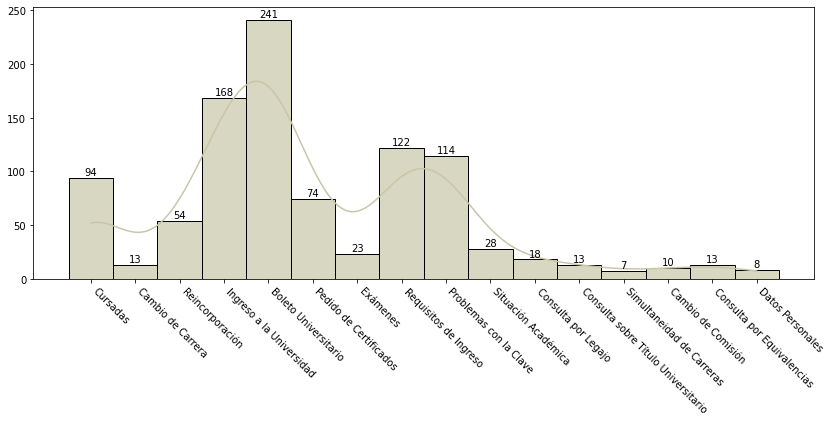

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def hist_clases(serie_clases, desc_plot, filename_plot):
  """
  Se plotean las clases en función de la distribución de la frecuencia
  observada en cada dataset
  """

  # Set figure size
  plt.figure(figsize=(14,5))

  ax = sns.histplot(serie_clases, kde=True, stat='count', 
                    bins=serie_clases.unique(), binwidth=0.06, 
                    color='#c8c6a7', alpha=0.7)

  ax.set_xticklabels(serie_clases.unique(),
                    rotation=-45, 
                    horizontalalignment='left', fontweight='light')

  for p in ax.patches:
      ax.annotate(f'{p.get_height():.0f}\n',
                  (p.get_x() + p.get_width() / 2, p.get_height()), 
                  ha='center', va='center', color='black')

  # Quito el nombre de los ejes (de forma rústica)
  plt.xlabel('', fontsize=12)
  plt.ylabel('', fontsize=12)

  # Guardo el plot en un png
  plt.savefig(filename_plot, optimize=True, transparent=True, bbox_inches = 'tight')

  # Muestro el gráfico con una descripción
  print(f'\t\t\tDistribución de clases para el {desc_plot}')
  plt.show()  

hist_clases(correos_etiquetados['clase'], 'Total dataset', 'histograma_total.png')

In [142]:
correos_etiquetados.shape

(1000, 24)

In [143]:
correos_etiquetados.to_csv('correos.csv')

In [144]:
!ls

correos.csv	     correos-train-80.csv  histograma_total.png  sample_data
correos-test-20.csv  funciones_dataset.py  __pycache__


## 6. Train/Test dataset

Ahora, se splitean los datasets a en una proporción 80/20. Estos datasets se utilizarán para _feature extraction_ y para la generación de los modelos:

In [145]:
# Separo datos de entrenamiento y testing
from sklearn.model_selection import train_test_split

X = correos_etiquetados.drop(columns=['clase'])
y = correos_etiquetados['clase']

# Separo en 80-20 entrenamiento/validación y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

Ahora unificamos X e y para persistir los datasets:

In [146]:
# Reordeno el índice para poder concatenar con el y_train e y_test

# Train
df_train = X_train.reset_index(drop=True)
df_train['clase'] = y_train.reset_index(drop=True)

# Test
df_test = X_test.reset_index(drop=True)
df_test['clase'] = y_test.reset_index(drop=True)

In [147]:
df_test[['consulta', 'clase']].head()

,consulta,clase
0,hace aproximadamente 1 mes que completé el formulario para poder obtener el boleto estudiantil y nunca obtuve respuesta,Boleto Universitario
1,clave,Problemas con la Clave
2,quiero hacer el cambio de carreta. de comercio a administracion. y empezar en el segundo cuatrimestre. este año no curse directamente,Cambio de Carrera
3,"solicite durante el transcurso de este primer cuatrimestre que se rectifique mi caligicacion de la asignatura medios de pago del comercio internacional. promovi esa asignatura con un 8 , pero en mi perfil esta con calificacion 7 . y aun no se ha solucionado.",Situación Académica
4,hola no me llega el msn para cambiar la contraseña para poder ingresar a mi situación académica. para anotarme a las materias de 2do cuatrimestre.,Problemas con la Clave


Por último se persisten en _Drive_:

In [148]:
# Me autentico en Drive
from google.colab import drive

# Guardo en Drive los datos de entrenamiento
df_train.to_csv('correos-train-jaiio-80.csv', index=False)
drive.mount('drive')
!cp correos-train-jaiio-80.csv "drive/My Drive/"

# Guardo en Drive los datos de testeo
df_test.to_csv('correos-test-jaiio-20.csv', index=False)
drive.mount('drive')
!cp correos-test-jaiio-20.csv "drive/My Drive/"

Mounted at drive
Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Referencias:
1. [Presentación](0) de apoyo al [Proyecto de Investigación](1) "Clasificación automática de correos electrónicos".

2. Clasificacion de textos por etiquetado de palabras: [short paper](2).

3. [API](3) del diccionario Collins.

4. [Funciones](4) de la [API](3) del diccionario Collins.

5. Librería [clusteval](5) para la evaluación KMeans.

[0]:https://docs.google.com/presentation/d/1-gdZ3dUI2pAfXM6Bgau53U7G4g2Bkv6DlxGESnu7A20/edit?usp=sharing 
[1]:https://github.com/jumafernandez/clasificacion_correos 
[2]:https://www.aaai.org/Papers/AAAI/2004/AAAI04-068.pdf
[3]:https://pypi.org/project/collins-client/
[4]:https://api.collinsdictionary.com/api/v1/documentation/html
[5]:https://clusteval.sdu.dk/1/mains